In [1]:
import numpy as np
from scipy.signal import butter, filtfilt, lfilter, get_window, windows, stft
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pywt

#### 1. Widar3.0 DFS Code

In [2]:
import numpy as np
from numpy.linalg import svd

def pca(X, n_components=None, centered=True, algorithm='svd',
        weights=None, variable_weights=None, missing_rows='complete',
        economy=True, tol=1e-6):
    """
    Principal Component Analysis (PCA) for complex-valued data matrices
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The complex-valued data matrix
    n_components : int, optional
        Number of components to keep
    centered : bool, default=True
        Whether to center the data before PCA
    algorithm : {'svd'}, default='svd'
        Algorithm to use (currently only SVD supported)
    weights : array-like of shape (n_samples,), optional
        Observation weights
    variable_weights : {'variance', array-like}, optional
        Variable weights specification
    missing_rows : {'complete'}, default='complete'
        Missing value handling method
    economy : bool, default=True
        Whether to return economy-size results
    tol : float, default=1e-6
        Tolerance for determining effective rank
        
    Returns
    -------
    coeff : ndarray of shape (n_features, n_components)
        Principal component coefficients (loadings)
    score : ndarray of shape (n_samples, n_components)
        Principal component scores
    latent : ndarray of shape (n_components,)
        Variance explained by each component
    tsquared : ndarray of shape (n_samples,)
        Hotelling's T-squared statistic
    explained : ndarray of shape (n_components,)
        Percentage of variance explained
    mu : ndarray of shape (n_features,)
        Column means (if centered)
    """
    
    X = np.asarray(X)
    n, p = X.shape
    
    # ================ Missing Value Handling ================
    nan_mask = np.isnan(X).any(axis=1)
    if missing_rows == 'complete':
        valid_rows = ~nan_mask
        X_clean = X[valid_rows]
        if weights is not None:
            weights = np.asarray(weights)[valid_rows]
    else:
        raise ValueError("Only 'complete' missing value handling supported")
    
    n_clean, p_clean = X_clean.shape
    
    # ================ Weight Initialization ================
    if weights is None:
        weights = np.ones(n_clean, dtype=X.dtype)
    else:
        weights = np.asarray(weights).astype(X.dtype)
    
    # ================ Variable Weights Handling ================
    if variable_weights == 'variance':
        if not centered:
            raise ValueError("Variance weights require centering")
        # Match MATLAB's wnanvar with ddof=1
        mu_clean = np.nanmean(X_clean, axis=0)
        X_centered_clean = X_clean - mu_clean
        var = np.nansum((X_centered_clean * np.conj(X_centered_clean)) * weights.reshape(-1,1), axis=0) / (np.sum(weights) - 1)
        variable_weights = 1 / np.real(var)
    elif variable_weights is None:
        variable_weights = np.ones(p, dtype=np.float64)
    else:
        variable_weights = np.asarray(variable_weights)
    
    # ================ Data Centering ================
    if centered:
        mu = np.nansum(X_clean * weights.reshape(-1,1), axis=0) / np.sum(weights)
        X_centered = X_clean - mu
    else:
        mu = np.zeros(p, dtype=X.dtype)
        X_centered = X_clean.copy()
    
    # ================ Weight Application ================
    sqrt_weights = np.sqrt(weights).reshape(-1,1)
    sqrt_var_weights = np.sqrt(variable_weights).reshape(1,-1)
    
    X_weighted = X_centered * sqrt_weights * sqrt_var_weights
    
    # ================ SVD Decomposition ================
    U, S, Vt = svd(X_weighted, full_matrices=False)
    coeff = (Vt.T / sqrt_var_weights.reshape(-1,1)).astype(X.dtype)
    
    # ================ Scores Calculation ================
    score = U * S
    score = score / sqrt_weights
    
    # ================ Sign Convention (MATLAB Compatibility) ================
    for i in range(coeff.shape[1]):
        col = coeff[:, i]
        max_idx = np.argmax(np.abs(col))
        max_val = col[max_idx]
        phase = np.angle(max_val)
        rotation = np.exp(-1j * phase)
        coeff[:, i] = (col * rotation).astype(X.dtype)
        score[:, i] = (score[:, i] * rotation).astype(X.dtype)
    
    # ================ Variance Explained ================
    dof = n_clean - (1 if centered else 0)
    latent = (S**2) / dof if dof > 0 else np.zeros_like(S)
    
    # ================ Economy Size Handling ================
    if economy:
        max_components = min(dof, p)
        coeff = coeff[:, :max_components]
        score = score[:, :max_components]
        latent = latent[:max_components]
    
    # ================ Component Selection ================
    if n_components is not None:
        coeff = coeff[:, :n_components]
        score = score[:, :n_components]
        latent = latent[:n_components]
    
    # ================ Explained Variance ================
    total_var = np.sum(np.real(latent))
    explained = (np.real(latent) / total_var * 100) if total_var > 0 else np.zeros_like(latent)
    
    # ================ Hotelling's T-Squared ================
    effective_rank = np.sum(latent > tol * np.max(latent))
    if effective_rank > 0:
        stand_scores = score[:, :effective_rank] / np.sqrt(latent[:effective_rank])
        tsquared = np.sum(np.abs(stand_scores)**2, axis=1)
    else:
        tsquared = np.zeros(n_clean, dtype=np.float64)
    
    # ================ NaN Reinsertion ================
    full_score = np.full((n, score.shape[1]), np.nan, dtype=score.dtype)
    full_score[valid_rows] = score
    score = full_score
    
    full_tsquared = np.full(n, np.nan, dtype=np.float64)
    full_tsquared[valid_rows] = tsquared
    
    return coeff, score, latent, full_tsquared, explained, mu

In [147]:
def tfrsp(x, t=None, N=None, h=None, trace=0):
    x = np.array(x)
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    xrow, xcol = x.shape
    if xcol != 1:
        raise ValueError("X must have one column")
    
    # Handle default parameters
    if t is None:
        t = np.arange(1, xrow + 1)
    else:
        t = np.array(t).flatten()
        if t.ndim != 1:
            raise ValueError("T must be a 1-D array")
    
    if N is None:
        N = xrow
    elif N <= 0:
        raise ValueError("N must be greater than zero")
    
    # Generate default window h
    if h is None:
        hlength = int(np.floor(N / 4))
        hlength += 1 - (hlength % 2)  # Ensure odd length
        if hlength <= 0:
            hlength = 1
        h = get_window('hamming', hlength)
    else:
        h = np.array(h).flatten()
        if len(h) % 2 == 0:
            raise ValueError("H must have odd length")
    
    # Normalize window to unit energy
    h = h / np.linalg.norm(h)
    Lh = (len(h) - 1) // 2
    
    if (N & (N - 1)) != 0:
        print("Note: For faster computation, N should be a power of two")
    
    tcol = len(t)
    tfr = np.zeros((N, tcol), dtype=np.complex_)
    
    for icol in range(tcol):
        ti = t[icol]
        ti_py = ti - 1  # Convert to 0-based index
        
        # Calculate valid tau range
        max_neg = min(int(round(N/2 - 1)), Lh, ti_py)
        max_pos = min(int(round(N/2 - 1)), Lh, xrow - 1 - ti_py)
        tau = np.arange(-max_neg, max_pos + 1)
        
        if len(tau) == 0:
            continue
        
        # Signal segment
        indices_x = ti_py + tau
        if np.any(indices_x < 0) or np.any(indices_x >= xrow):
            raise IndexError("Signal indices out of bounds")
        x_segment = x[indices_x, 0]
        
        # Window segment
        h_segment = h[Lh + tau]
        # Normalize the window segment
        h_norm = np.linalg.norm(h_segment)
        if h_norm == 0:
            h_segment_normalized = h_segment
        else:
            h_segment_normalized = h_segment / h_norm
        
        # Compute product and place in tfr
        product = x_segment * h_segment_normalized.conj()
        indices_tfr = np.mod(N + tau, N)
        tfr[indices_tfr, icol] = product
        
        if trace and (icol + 1) % max(1, tcol // 10) == 0:
            print(f"Progress: {icol + 1}/{tcol}")
    
    # Compute FFT and magnitude squared
    tfr = np.abs(np.fft.fft(tfr, axis=0)) ** 2
    
    # Frequency vector
    f = np.fft.fftfreq(N).reshape(-1, 1)
    
    return tfr, t, f

In [148]:
def get_doppler_spectrum(csi_data):
    '''
    param: csi_data: 输入的CSI数据, shape为(time_length, rx_acnt, subcarrier_num)
    param: rx_acnt: 接收天线数量
    '''
    time, rx_acnt, subcarrier_num = csi_data.shape

    # Set-Up Parameters
    samp_rate = 1000
    half_rate = samp_rate / 2
    uppe_orde = 6
    uppe_stop = 60
    lowe_orde = 3
    lowe_stop = 2

    # Butterworth滤波器设计
    lu, ld = butter(uppe_orde, uppe_stop / half_rate, 'low')
    hu, hd = butter(lowe_orde, lowe_stop / half_rate, 'high')

    # 频率分箱
    freq_bins_unwrap = np.concatenate([np.arange(0, samp_rate/2), np.arange(-samp_rate/2, 0)])
    freq_bins_unwrap = freq_bins_unwrap / samp_rate
    freq_lpf_sele = (freq_bins_unwrap <= uppe_stop / samp_rate) & (freq_bins_unwrap >= -uppe_stop / samp_rate)
    freq_lpf_positive_max = np.sum(freq_lpf_sele[1:int(len(freq_lpf_sele)/2)])
    freq_lpf_negative_min = np.sum(freq_lpf_sele[int(len(freq_lpf_sele)/2):])

    # 多普勒频谱初始化
    # csi_data = pca_denoise(csi_data)
    doppler_spectrum = np.zeros((1 + int(freq_lpf_positive_max) + int(freq_lpf_negative_min), int(np.floor(csi_data.shape[0]))))

    # 降采样
    csi_data = csi_data[::1, :, :]

    # 选择天线对
    csi_mean = np.mean(np.abs(csi_data), axis=0)
    csi_var = np.sqrt(np.var(np.abs(csi_data), axis=0))
    csi_mean_var_ratio = csi_mean / csi_var
    idx = np.argmax(np.mean(csi_mean_var_ratio, axis=-1))
    csi_data_ref = np.tile(csi_data[:, idx, :], (1, rx_acnt)).reshape(time, rx_acnt, -1)

    # 幅度调整
    csi_data_adj = np.zeros_like(csi_data)
    csi_data_ref_adj = np.zeros_like(csi_data_ref)
    alpha_sum = 0
    for acnt in range(rx_acnt):
        for subcarrier in range(subcarrier_num):
            amp = np.abs(csi_data[:, acnt, subcarrier])
            alpha = np.min(amp[amp != 0])
            alpha_sum += alpha
            csi_data_adj[:, acnt, subcarrier] = np.abs(np.abs(csi_data[:, acnt, subcarrier]) - alpha) * np.exp(1j * np.angle(csi_data[:, acnt, subcarrier]))
    beta = 1000 * alpha_sum / (subcarrier_num * rx_acnt)
    for acnt in range(rx_acnt):
        for subcarrier in range(subcarrier_num):
            csi_data_ref_adj[:, acnt, subcarrier] = (np.abs(csi_data_ref[:, acnt, subcarrier]) + beta) * np.exp(1j * np.angle(csi_data_ref[:, acnt, subcarrier]))

    # 共轭乘法
    conj_mult = csi_data_adj * np.conj(csi_data_ref_adj)
    conj_mult = np.concatenate([conj_mult[:, :idx, :], conj_mult[:, idx+1:, :]], axis=1)

    # 滤波
    for acnt in range(rx_acnt-1):
        for subcarrier in range(subcarrier_num):
            conj_mult[:, acnt, subcarrier] = lfilter(lu, ld, conj_mult[:, acnt, subcarrier])
            conj_mult[:, acnt, subcarrier] = lfilter(hu, hd, conj_mult[:, acnt, subcarrier])

    # PCA分析
    conj_mult_temp = conj_mult.reshape(conj_mult.shape[0], -1)
    coeff, score, latent, tsquared, explained, mu = pca(conj_mult_temp)
    conj_mult_pca = np.dot(conj_mult_temp,coeff[:, 0])
    
    # 时频分析
    freq_time_prof_allfreq, t, f = tfrsp(conj_mult_pca, np.arange(conj_mult_pca.shape[0]), 1000, windows.gaussian(125,18))

    # 选择关心的频率
    freq_time_prof = freq_time_prof_allfreq[freq_lpf_sele, :]
    freq_time_prof = freq_time_prof / np.sum(freq_time_prof, axis=0)

    # 频率分箱
    freq_bin = np.concatenate([np.arange(0, freq_lpf_positive_max+1), np.arange(-freq_lpf_negative_min, 0)])

    # 存储多普勒频谱
    if freq_time_prof.shape[1] >= doppler_spectrum.shape[1]:
        doppler_spectrum[:, :] = freq_time_prof[:, :doppler_spectrum.shape[1]]
    else:
        doppler_spectrum[:, :] = np.concatenate([freq_time_prof, np.zeros((doppler_spectrum.shape[0], doppler_spectrum.shape[1] - freq_time_prof.shape[1]))], axis=1)

    return doppler_spectrum, t, freq_bin

In [154]:
from scipy.io import loadmat
csi_data = loadmat('../CSI-Data-Fu/user1-1-1-1-6-r2.mat')['csi_data']
csi_data = csi_data.reshape(csi_data.shape[0], 3, -1)

dfs, t, f = get_doppler_spectrum(csi_data)

Note: For faster computation, N should be a power of two


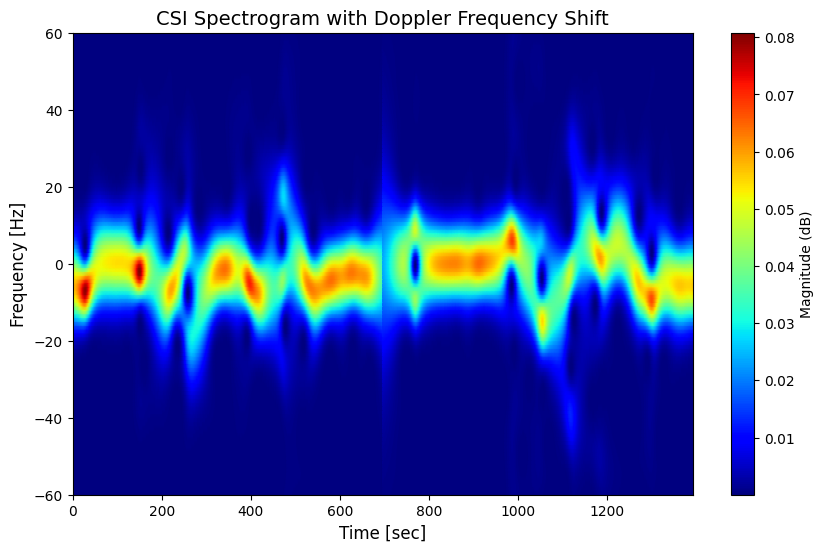

In [155]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, np.fft.fftshift(f), np.fft.fftshift(dfs), shading='gouraud', cmap='jet')
plt.title('CSI Spectrogram with Doppler Frequency Shift', fontsize=14)
plt.ylabel('Frequency [Hz]', fontsize=12)
plt.xlabel('Time [sec]', fontsize=12)
plt.colorbar(label='Magnitude (dB)')